# 本地ONNXRuntime部署-单张图像预测

同济子豪兄 2023-7-18 8-20

## 导入工具包

In [7]:
import onnxruntime
import numpy as np
import cv2

import torch

import matplotlib.pyplot as plt
%matplotlib inline

## 载入 ONNX 模型，获取 ONNX Runtime 推理器

In [2]:
# ONNX 模型路径
onnx_path = 'mmseg2onnx_fastscnn/end2end.onnx'

In [3]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:56: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  "Available providers: '{}'".format(name, ", ".join(available_provider_names))


## 构造输入，获取输出结果

在`pipeline.json`中，查看预处理方式

In [8]:
x = torch.randn(1, 3, 1024, 2048).numpy()

In [9]:
x.shape

(1, 3, 1024, 2048)

In [10]:
# onnx runtime 输入
ort_inputs = {'input': x}

# onnx runtime 输出
ort_output = ort_session.run(['output'], ort_inputs)[0]

In [11]:
ort_output.shape

(1, 1, 1024, 2048)

## 载入一张真实图像

In [12]:
img_path = 'watermelon_test1.jpg'

In [13]:
img_bgr = cv2.imread(img_path)

In [14]:
img_bgr.shape

(3712, 5568, 3)

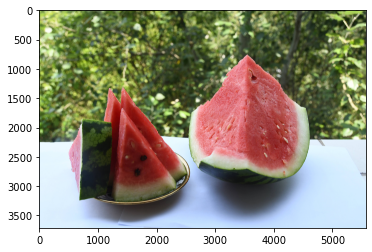

In [15]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 从原图中裁剪出宽高比1:2的图像

In [16]:
# 获取原图宽高
h, w = img_bgr.shape[0], img_bgr.shape[1]

# 原图中心点坐标
center_x, center_y = w // 2, h // 2

In [18]:
ratio = 2 # 设置裁剪尺寸缩放系数（1024的倍数，不要超过原图范围）

In [19]:
new_h = 1024 * ratio
new_w = 2048 * ratio

img_bgr_crop = img_bgr[int(center_y-new_h/2):int(center_y+new_h/2), int(center_x-new_w/2):int(center_x+new_w/2)]

In [20]:
img_bgr_crop.shape

(2048, 4096, 3)

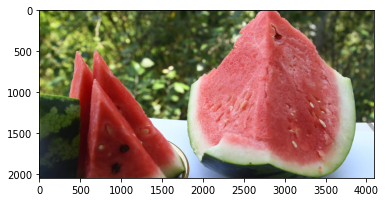

In [22]:
plt.imshow(img_bgr_crop[:,:,::-1])
plt.show()

## 缩放至模型要求的高1024 x 宽2048像素

In [23]:
img_bgr_resize = cv2.resize(img_bgr_crop, (2048, 1024)) # 缩放尺寸

In [24]:
img_bgr_resize.shape

(1024, 2048, 3)

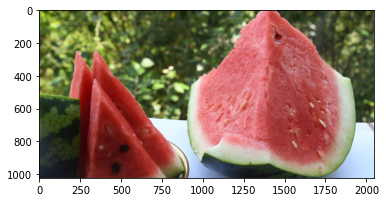

In [26]:
plt.imshow(img_bgr_resize[:,:,::-1])
plt.show()

## 预处理

In [29]:
img_tensor = img_bgr_resize

# BGR 三通道的均值
mean = (123.675, 116.28, 103.53)

# BGR 三通道的标准差
std = (58.395, 57.12, 57.375)

# 归一化
img_tensor = (img_tensor - mean) / std
img_tensor = img_tensor.astype('float32')

# BGR 转 RGB
img_tensor = cv2.cvtColor(img_tensor, cv2.COLOR_BGR2RGB)

# 调整维度
img_tensor = np.transpose(img_tensor, (2, 0, 1))
# 扩充 batch-size 维度
input_tensor = np.expand_dims(img_tensor, axis=0)

In [30]:
input_tensor.shape

(1, 3, 1024, 2048)

## ONNX Runtime预测

In [31]:
# ONNX Runtime 输入
ort_inputs = {'input': input_tensor}

In [32]:
# onnx runtime 输出
ort_output = ort_session.run(['output'], ort_inputs)[0]

In [33]:
ort_output.shape

(1, 1, 1024, 2048)

In [34]:
pred_mask = ort_output[0][0]

In [35]:
pred_mask.shape

(1024, 2048)

In [36]:
np.unique(pred_mask)

array([0, 1, 2, 3, 4, 5], dtype=int64)

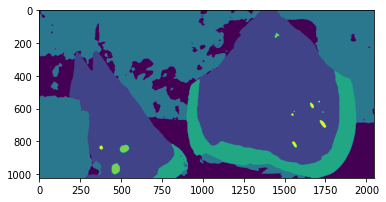

In [37]:
plt.imshow(pred_mask)
plt.show()

## 各类别的配色方案

In [38]:
# 各类别的配色方案（BGR）

palette = [
    ['background', [127,127,127]],
    ['red', [0,0,200]],
    ['green', [0,200,0]],
    ['white', [144,238,144]],
    ['seed-black', [30,30,30]],
    ['seed-white', [8,189,251]]
]

palette_dict = {}
for idx, each in enumerate(palette):
    palette_dict[idx] = each[1]

In [39]:
palette_dict

{0: [127, 127, 127],
 1: [0, 0, 200],
 2: [0, 200, 0],
 3: [144, 238, 144],
 4: [30, 30, 30],
 5: [8, 189, 251]}

## 叠加在原图上可视化

In [40]:
opacity = 0.3 # 透明度，越大越接近原图

In [41]:
# 将预测的整数ID，映射为对应类别的颜色
pred_mask_bgr = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3))
for idx in palette_dict.keys():
    pred_mask_bgr[np.where(pred_mask==idx)] = palette_dict[idx]
pred_mask_bgr = pred_mask_bgr.astype('uint8')

# 将语义分割预测图和原图叠加显示
pred_viz = cv2.addWeighted(img_bgr_resize, opacity, pred_mask_bgr, 1-opacity, 0)

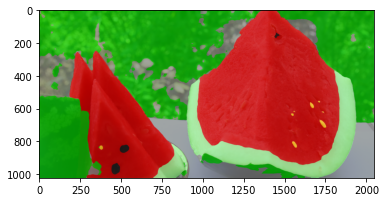

In [42]:
plt.imshow(pred_viz[:,:,::-1])
plt.show()

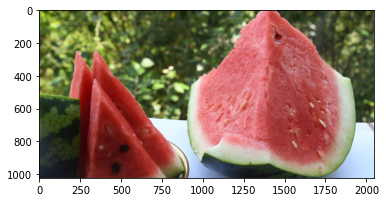

In [44]:
plt.imshow(img_bgr_resize[:,:,::-1])
plt.show()

In [43]:
cv2.imwrite('N2.jpg', pred_viz)

True